## Chapter 4 : Classification
- softmax:
  $y_i = \frac{\exp(o_i)}{\sum_j \exp(o_j)}$, often minus max(oj) to get numerical stable
- Information theory
  - cross-entropy loss：$l(y, \hat y) = - \sum y_i * \log(\hat y_i)$
  - amount of information $\log{\frac{1}{P(j)}} = - \log{P(j)}$ 
  - entorpy $H[P] = \sum -P(j) \log{P(j)}$
  - cross-entorpy $H(P, Q) = \sum -P(j) \log{Q(j)}, ~ P=Q \rightarrow H(P, Q) = H(P, P) = H(P)$. In pytorch, F.cross_entropy will do the softmax for you.
- Image Classification Rules:
  - image stored in (channel, height, weight) manner.
- Distrubution shift:
  - Covariate Shift (feature shift): $p(x) \neq q(x), p(y|x) = q(y|x)$
    - For example: p(x) and q(x) are features of oral and urban house, y is the price, we assume the feature and label relation is the same
    - Method: weighted by $\beta(x) = p(x) / q(x) \rightarrow \int\int l(f(x), y)p(y|x)p(x)dxdy = \int\int l(f(x), y)q(y|x)q(x) \frac{p(x)}{q(x)}dxdy \rightarrow \sum_i \beta_i l(f(x_i), y_i)$, $\beta$ can be obtained with logistic regression.
  - Label Shift, $p(y) \neq q(y), p(x|y) = q(x|y)$, the same method $\beta(y) = p(y) / q(y)$, but now $q(y)$ is hard to get, we need compute a confusion matrix on the val data then use the model to pridcit the distrubution of the $q(y)$
  - Concept Shift (the concept of the label)

In [1]:
%matplotlib inline
import time
import torch
import torchvision
from torchvision import transforms

In [28]:
import matplotlib.pyplot as plt

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_utils`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = d2l.numpy(img)
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [24]:
class FashionMNIST():
    def __init__(self, batch_size = 8, resize = (28, 28), num_workers = 4, root = ""):
        self.root = root
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()]) # The ToTensor will make train[id] data to tensor and (0, 1) and (c, h, w)
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=False)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=False)

    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)

    def text_labels(self, indices):
        """Return text labels."""
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]

    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        show_images(X.squeeze(1), nrows, ncols, titles=labels)

In [78]:
fashion_mnist_data = FashionMNIST(batch_size = 256, root = "../../Data")
fashion_mnist_data.train.data.shape, fashion_mnist_data.train[0][0].dtype, fashion_mnist_data.train.data[0].dtype

(torch.Size([60000, 28, 28]), torch.float32, torch.uint8)

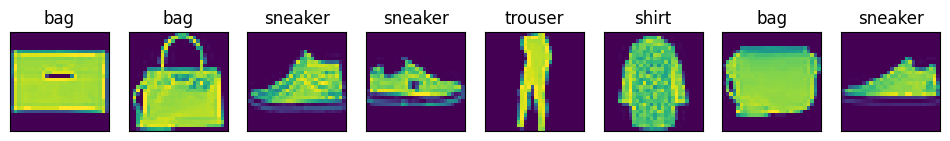

In [33]:
fashion_mnist_data.visualize(next(iter(fashion_mnist_data.get_dataloader(True))))

In [46]:
fashion_mnist_data.train[0][0].reshape(28, 28).shape

torch.Size([28, 28])

In [79]:
import torch.nn as nn
class BaseModel(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(32), nn.LazyLinear(num_outputs))

    def forward(self, x):
        return self.net(x)

In [80]:
base_model = BaseModel(10)
print(base_model(fashion_mnist_data.train[0][0]).shape)

torch.Size([1, 10])


In [81]:
import torch.optim as optim
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_model.parameters(), lr=0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device :", device)
base_model.to(device)

train_loader = fashion_mnist_data.get_dataloader(True)  # 获取训练数据加载器
val_loader = fashion_mnist_data.get_dataloader(False)  # 获取训练数据加载器

loss_train, loss_val, correct, total = 0, 0, 0, 0
for epoch in range(epochs):
    base_model.train()  # 设置模型为训练模式

    for x, y in train_loader:  # 遍历整个数据集
        x, y = x.to(device), y.to(device)  # 将数据移动到 GPU（如果可用）

        # 前向传播
        y_hat = base_model(x)
        loss = criterion(y_hat, y)  # 计算损失
        loss_train += loss.item()
        # 反向传播和优化
        optimizer.zero_grad()  # 清除梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

    base_model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_hat = base_model(x)
            loss = criterion(y_hat, y)
            loss_val += loss.item()
            _, predicted = y_hat.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
            
    print(f"Epoch [{epoch+1}/{epochs}], train loss: {loss_train / len(train_loader):.4f}, val loss: {loss_val / len(val_loader):.4f}")
    loss_train, loss_val, correct, total = 0, 0, 0, 0
    

Using device : cuda
Epoch [1/10], train loss: 1.6369, val loss: 1.1894
Epoch [2/10], train loss: 1.0114, val loss: 0.9074
Epoch [3/10], train loss: 0.8351, val loss: 0.7971
Epoch [4/10], train loss: 0.7503, val loss: 0.7330
Epoch [5/10], train loss: 0.6966, val loss: 0.6885
Epoch [6/10], train loss: 0.6573, val loss: 0.6551
Epoch [7/10], train loss: 0.6272, val loss: 0.6309
Epoch [8/10], train loss: 0.6033, val loss: 0.6093
Epoch [9/10], train loss: 0.5842, val loss: 0.5920
Epoch [10/10], train loss: 0.5682, val loss: 0.5778


In [82]:
for x, y in train_loader:  # 遍历整个数据集
    x, y = x.to(device), y.to(device)
    print(x.device)
    break

cuda:0
